In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
import sklearn as sk

C:\Users\kanev\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def df_transformation(df):
    df_temp = df[features]
    df_temp['datetime'] = df_temp.datetime.dt.strftime('%Y-%m-%d %H:%M:%S').astype('datetime64[ns]')

    output = df_temp.groupby(by=["datetime"], dropna=False).mean().reset_index()
    
    return output 

In [3]:
# Create a custom function for data transformation
# May as well import all of these features into the initial dataframe, you can cut it down..
# ..when you do the X,y train/test split
features = ['datetime',
          'latitude',
          'longitude',
          'absoluteAltitude', 
          'magneticHeading',
          'trueHeading', 
          'groundSpeed', 
          'trueAirspeed',
          'pitch', 
          'roll',
          'yaw',
          'angleOfAttack',
          'flightPathAngle',
          'verticalFlightPathAngle',
          'horizontalFlightPathAngle',
          'rollAcceleration',
          'pitchAcceleration',
          'yawAcceleration',
          'e1N1ng',
          'e2N1ng',
          'e1N2nf',
          'e2N2nf',
          'mainRotorRpm',
          'tailRotorRpm',
          'mainRotorTorque',
          'e1Itt',
          'e2Itt',
          'mainRotorInducedInflow',
          'flightDirectorPitch',
          'flightDirectorRoll',
          'climbOrDescentRate', 
          'hasWeightOnWheels',
          'turnRate to degPerSec',
          'cyclicPositionPitch',
          'cyclicPositionRoll',
          'collectivePosition',
          'antiTorquePedalPosition',
          'throttlePosition',
          'e1Torque',
          'e2Torque',
]


In [4]:
# reading files from 9/19 dataset
#df1 = pd.read_csv('SimData_2022.09.19_16.00.36.csv.roar.csv',
#                parse_dates = {'datetime': ['date', 'time']},
#                low_memory=False)
#df1 = df_transformation(df1)


#df2 = pd.read_csv('SimData_2022.09.19_16.38.20.csv.roar.csv',
#                parse_dates = {'datetime': ['date', 'time']},
#                low_memory=False)
#df2 = df_transformation(df2)


df3 = pd.read_csv('SimData_2022.09.19_17.51.37.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
df3 = df_transformation(df3)



# reading files from 9/20 dataset
first_file = pd.read_csv('SimData_2022.09.20_16.22.07.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
first_file = df_transformation(first_file)


second_file = pd.read_csv('SimData_2022.09.20_16.28.31.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
second_file = df_transformation(second_file)


# reading file from 9/22 dataset
#df4 = pd.read_csv('SimData_2022.09.22_17.11.56.csv.roar.csv',
#                parse_dates = {'datetime': ['date', 'time']},
#                low_memory=False)
#df4 = df_transformation(df4)

C:\Users\kanev\AppData\Local\Temp\ipykernel_528\17026926.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['datetime'] = df_temp.datetime.dt.strftime('%Y-%m-%d %H:%M:%S').astype('datetime64[ns]')
C:\Users\kanev\AppData\Local\Temp\ipykernel_528\17026926.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['datetime'] = df_temp.datetime.dt.strftime('%Y-%m-%d %H:%M:%S').astype('datetime64[ns]')
C:\Users\kanev\AppData\Local\Temp\ipykernel_528\17026926.py:3: SettingWithCopyWarning: 
A value is t

In [5]:
#Combine files
df = pd.concat([first_file,second_file, df3]).reset_index()

# Dataframe for Hover Taxi maneuver# 

In [6]:
df_h = df.copy()
df_h['hover'] = 0

df_h.loc[(df_h['datetime'].between('2022-09-19 21:57:07' , '2022-09-19 21:59:20' , inclusive='both')),['hover']] = 1
df_h.loc[(df_h['datetime'].between('2022-09-19 22:08:15' , '2022-09-19 22:10:24' , inclusive='both')),['hover']] = 1
df_h.loc[(df_h['datetime'].between('2022-09-20 20:28:44' , '2022-09-20 20:30:06' , inclusive='both')),['hover']] = 1
df_h.loc[(df_h['datetime'].between('2022-09-20 20:30:31' , '2022-09-20 20:32:16' , inclusive='both')),['hover']] = 1
df_h.loc[(df_h['datetime'].between('2022-09-20 20:32:39' , '2022-09-20 20:34:06' , inclusive='both')),['hover']] = 1
df_h.loc[(df_h['datetime'].between('2022-09-20 20:34:50' , '2022-09-20 20:36:51' , inclusive='both')),['hover']] = 1
df_h.loc[(df_h['datetime'].between('2022-09-22 21:20:41' , '2022-09-22 21:23:56' , inclusive='both')),['hover']] = 1
df_h.loc[(df_h['datetime'].between('2022-09-22 21:28:35' , '2022-09-22 21:29:46' , inclusive='both')),['hover']] = 1
df_h.loc[(df_h['datetime'].between('2022-09-22 21:44:09' , '2022-09-22 21:45:31' , inclusive='both')),['hover']] = 1


In [7]:
df_h['hover'].value_counts()

0    1835
1     663
Name: hover, dtype: int64

# Edit DF for ML, Class Balance, Select desired features

In [8]:
#Edit the model features to whatever you want to include in your model
all_features = [ 'hasWeightOnWheels',
            'absoluteAltitude',
                 'magneticHeading', 
                 'groundSpeed', 
                 'climbOrDescentRate',
                 'turnRate to degPerSec',
                 'cyclicPositionPitch',
                 'cyclicPositionRoll',
                 'collectivePosition',
                 'antiTorquePedalPosition',
                 'throttlePosition',
                 'e1Torque',
                 'e2Torque', 'hover']

df_h = df_h[all_features]

In [9]:
df_h['hover'].value_counts()

0    1835
1     663
Name: hover, dtype: int64

In [10]:
xg_features = [ 'hasWeightOnWheels',
            'absoluteAltitude',
                 'magneticHeading', 
                 'groundSpeed', 
                 'climbOrDescentRate',
                 'turnRate to degPerSec',
                 'cyclicPositionPitch',
                 'cyclicPositionRoll',
                 'collectivePosition',
                 'antiTorquePedalPosition',
                 'throttlePosition',
                 'e1Torque',
                 'e2Torque']

In [11]:
ros = RandomOverSampler(sampling_strategy='minority')

In [12]:
x, y = df_h[xg_features], df_h['hover']

In [13]:
x, y = ros.fit_resample(x, y)

In [14]:
y.value_counts()

0    1835
1    1835
Name: hover, dtype: int64

# XGBoost Model Test

In [15]:
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x,y,test_size=0.2,random_state=777)

In [16]:
model = XGBClassifier(use_label_encoder=False)
model.fit(x_train, y_train)

[15:59:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kanev\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [17]:
y_train_pred = model.predict(x_train)

In [18]:
y_pred = model.predict(x_test)

In [24]:
train_acc = sk.metrics.accuracy_score(y_train, y_train_pred)
test_acc = sk.metrics.accuracy_score(y_test, y_pred)

In [25]:
print("Train Accuracy: %.2f%%" % (train_acc * 100.0))
print("Test Accuracy: %.2f%%" % (test_acc * 100.0))

Train Accuracy: 100.00%
Test Accuracy: 99.73%


In [27]:
train_roc = sk.metrics.roc_auc_score(y_train, y_train_pred)
test_roc = sk.metrics.roc_auc_score(y_test, y_pred)

In [28]:
print("Train ROC AUC Score: %.2f%%" % (train_roc * 100.0))
print("Test ROC AUC Score: %.2f%%" % (test_roc * 100.0))

Train ROC AUC Score: 100.00%
Test ROC AUC Score: 99.72%


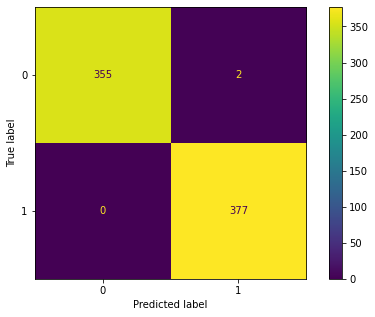

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
cmp = sk.metrics.ConfusionMatrixDisplay(sk.metrics.confusion_matrix(y_test, y_pred),)
cmp.plot(ax=ax)
plt.show()

C:\Users\kanev\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


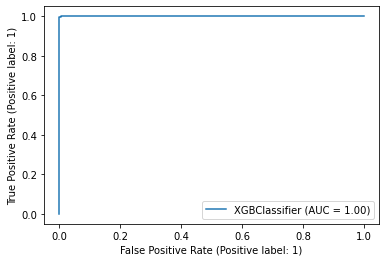

In [29]:
sk.metrics.plot_roc_curve(model, x_test, y_test)
plt.show()